## Operational Radar Tutorial Introduction

So far we've learnt how to transform reflectivity into rain rate and generate Cartesian gridded radar data.
In this tutorial we're to extend those skills by covering:

1. How to implement a hail size retrieval
2. How to produce accumulated analysis for assessing radar retrievals across longer time spans
3. Exporting gridded radar fields to geotif


## Hail Size Retrieval

One of the most commonly used hail size retrievals is the Maximum Estimated Size of Hail (MESH). This technique was first introduced by [Witt et al. 1998.](https://journals.ametsoc.org/view/journals/wefo/13/2/1520-0434_1998_013_0286_aehdaf_2_0_co_2.xml) and more recently updated by [Muillo and Homeyer 2019](http://weather.ou.edu/~chomeyer/assets/murillo---homeyer-2019.pdf). It can be applied to any volumetric dataset which contains reflectivity (including level 1 of the operational radar archive). The technique also ingests the altitude of the 0C and -20C isotherm. Hail size is estimated by using a weighted (by Z and T) integration of the vertical reflectivity column above the freezing level. It's considered a fairly crude technique, but still provides reasonable skill in most cases.

This retrieval along with polarimetric hail size retrievals is avaliable in the [PyHail](https://github.com/joshua-wx/PyHail) library. For this tutorial, the files containing the MESH implementation have been copied into the tutorial folder.

In [33]:
#First, let's use the scripts from Part 3 of the Introduction to load up hailstorm case for Brisbane

import os #used for system commands
import tempfile #used to create temporary folders to store data
import zipfile #used to extract tar files
import urllib #used to download data via http
from glob import glob #used for manipulating pathnames

from matplotlib import pyplot as plt #plotting toolkit
import cartopy.crs as ccrs
import numpy as np
import pyart #python radar toolkit
import mesh #from the pyhail library

"""
Options to define our data selection and plotting
"""

#Specific the radar and date we want to download
radar_id     = '50' #this is the Marburg radar near Brisbane. if using a single digit, include a leading 0, e.g., '02'. Complete list of radar id's is on openradar.io
date_str     = '20201031' #in yyyymmdd
base_url     = 'http://dapds00.nci.org.au/thredds/fileServer/rq0' #base url for NCI server

"""
here we build the server request url, download data and unzip
"""

#step 1: build request url and download zip file
zip_fn       = radar_id + '_' + date_str + '.pvol.zip'
request_url  = '/'.join([base_url, radar_id, date_str[0:4], 'vol', zip_fn])
print('my request is ',request_url)
#download the zip file
urllib.request.urlretrieve(request_url, zip_fn)

#step 2: extract the zip file to a temporary directory
temp_dir = tempfile.mkdtemp()
zip_fh = zipfile.ZipFile(zip_fn)
zip_fh.extractall(path = temp_dir)
zip_fh.close()

#step 3: list all the volumes extracted from the zip file
file_list = sorted(glob(temp_dir + '/*'))
#remove zip
os.system('rm ' + zip_fn)
print('data download complete')

#plan (40min)

#simple retrievals (ZR, MESH)

#simple gridding (pyart)

#simple mapping (inc geotif)

#showcase advection correction (PySTEPS)

my request is  http://dapds00.nci.org.au/thredds/fileServer/rq0/50/2020/vol/50_20201031.pvol.zip
data download complete


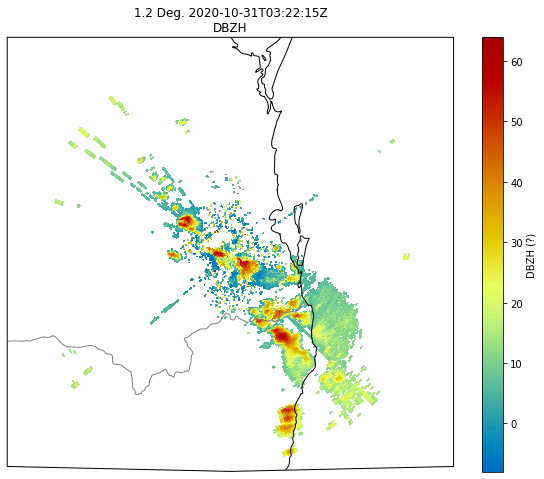

In [48]:
"""
Next, Select a file from the list and plot
"""

#select index from file list
my_index = 20
#read in radar object using pyart
radar = pyart.aux_io.read_odim_h5(file_list[my_index], file_field_names=True)
#unforuntately the radar lat and lon are missing, so we need to add these
radar.latitude['data'] = np.array([-27.608])
radar.longitude['data'] = np.array([152.539])
radar.altitude['data'] = np.array([371.06])

#generate display object
display = pyart.graph.RadarMapDisplay(radar)
#plot reflectivity field from a single tilt (this function includes a basemap)
fig = plt.figure(figsize=(10, 8), facecolor='w')
display.plot_ppi_map('DBZH', 1,
                            vmin=-8, vmax=64, cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                            resolution='10m')

/home/meso/miniconda3/envs/radar-dev/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/home/meso/miniconda3/envs/radar-dev/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


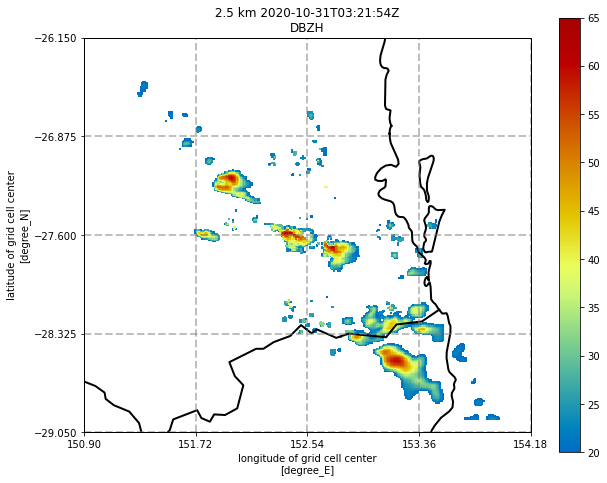

In [54]:
#Next, let's interpolate this onto a Cartesian grid
grid = pyart.map.grid_from_radars(radar, grid_shape=(41, 301, 301),
                                  grid_limits=((0, 20e3), (-150e3, 150e3), (-150e3, 150e3)),
                                  weighting_function='Barnes2')
#and plot our gridded radar dataset
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
grid_display = pyart.graph.GridMapDisplay(grid)
grid_display.plot_grid('DBZH',level=5, vmin=20, mask_outside=True) #level=4 is the 5th slice in the 3D interpolated field (2 km altitude)

/home/meso/dev/AMOS_2021/02 - Operational Network/mesh.py:146: RuntimeWarning: invalid value encountered in less_equal
  # calc reflectivity weighting function
/home/meso/dev/AMOS_2021/02 - Operational Network/mesh.py:147: RuntimeWarning: invalid value encountered in greater_equal
  weight_ref = (refl_grid - z_lower_bound)/(z_upper_bound - z_lower_bound)
/home/meso/dev/AMOS_2021/02 - Operational Network/mesh.py:178: RuntimeWarning: divide by zero encountered in log
  
/home/meso/miniconda3/envs/radar-dev/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/home/meso/miniconda3/envs/radar-dev/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is depreca

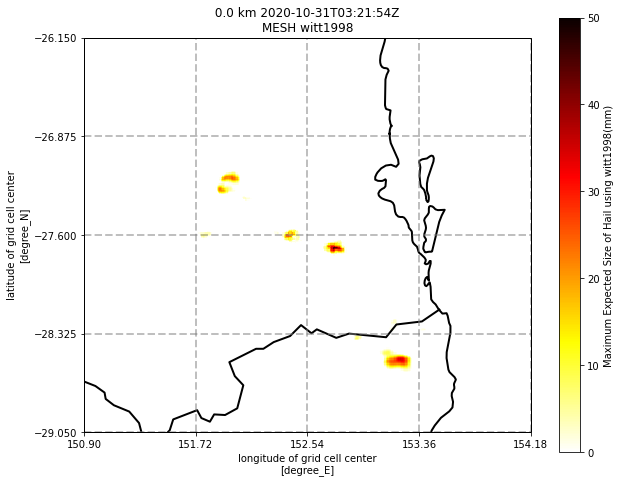

In [50]:
#now we can retrieve hail size using MESH
#For the case of demonstration, let's define the 0C and -20C levels to be 3000m and 7000m respectively.
grid = mesh.main(grid, 'DBZH', temph_data=[3000,7000], mesh_method='witt1998')
#and plot
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
grid_display = pyart.graph.GridMapDisplay(grid)
#note: MESH is a 2D field, and is stored in the first level of the 3D MESH field
grid_display.plot_grid('mesh_witt1998',0, vmin=0, vmax=50, cmap='hot_r')

In [59]:
#Next step is to produce these MESH grids for every radar volume during the event, and create a maximum mesh field across all of these timesteps.
#This is the first step towards producing a climatology.

#let's define a range of indices to use (this can be ignored if you want to process the entire day)
start_index = 10
end_index = 30

#create an empty grid

acc_mesh = np.zeros([301,301])

for i in range(start_index, end_index+1):
    #read in radar object using pyart
    radar = pyart.aux_io.read_odim_h5(file_list[i], file_field_names=True)
    #Next, let's interpolate this onto a Cartesian grid
    grid = pyart.map.grid_from_radars(radar, grid_shape=(41, 301, 301),
                                      grid_limits=((0, 20e3), (-150e3, 150e3), (-150e3, 150e3)),
                                      weighting_function='Barnes2')
    #For the case of demonstration, let's define the 0C and -20C levels to be 3000m and 7000m respectively.
    grid = mesh.main(grid, 'DBZH', temph_data=[3000,7000], mesh_method='witt1998')
    acc_mesh = np.

(301, 301)


In [ ]:
#Finally, we can output the MESH field as a geotif for use in GIS software.